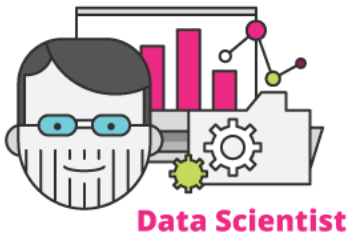

# <center>Segmenting and Clustering Neighborhoods in Toronto </center>

# Introduction

This project is to explore, segment, and cluster the neighborhoods in the city of Toronto. The neighborhood data is not readily available on the internet. We need to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas dataframe.mOnce the data is in a structured format, we can explore and cluster the neighborhoods in the city of Toronto.

## Import the Library

In [32]:
!conda install -c conda-forge folium=0.5.0 --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge beautifulsoup4

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.8.0       |           py36_0         144 KB  conda-forge

The following packages will be UPDATED:

    beautifulsoup4: 4.7.1-py36_1 --> 4.8.0-py36_0 conda-forge


beautifulsoup4-4.8.0 | 144 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [34]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import requests

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

from urllib.request import urlopen
import requests
import ssl

print('Libraries imported.')

Libraries imported.


## 1. Download and Explore the Dataset 

In [38]:
context = ssl._create_unverified_context()
wikiurl = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto'
html = urlopen(wikiurl, context=context)
bsObj = BeautifulSoup(html.read(), 'lxml')

In [39]:
neighborhoodItems = bsObj.find_all('div', {'style': 'padding:0em 0.25em'})[:6]
boItems = bsObj.find_all('th', {'class': 'navbox-group'})[:6]
boList = []
for item in boItems:
    boList.append(item.find('a').contents[0])
nbDict = {}
for i in range(6):
    nbDict[boList[i]] = [[x.contents[0], x.get('href')] for x in neighborhoodItems[i].find_all('a')]
temp = []
for item in nbDict.keys():
    for neigh in nbDict[item]:
        if neigh in temp:
            nbDict[item].remove(neigh)
        else:
            temp.append(neigh)
#print(nbDict)

In [40]:
wikiurl = 'https://en.wikipedia.org'
latlonDict = {}
for i in nbDict.keys():
    for j in range(len(nbDict[i])):
        nbUrl = wikiurl+str(nbDict[i][j][1])
        nbhtml = urlopen(nbUrl, context=context)
        nbbsObj = BeautifulSoup(nbhtml.read(), 'lxml')
        try:
            latlon = nbbsObj.find('span', {'class': 'geo'}).contents[0]
            latlonDict[nbDict[i][j][0]]=[float(x) for x in latlon.split('; ')]
        except:
            continue
print(latlonDict)

{'Alexandra Park': [43.65, -79.4], 'Allenby': [43.7096995, -79.4151072], 'The Annex': [43.67, -79.404], 'The Beaches': [43.667266, -79.297128], 'Bedford Park': [43.73, -79.411], 'Bickford Park': [43.65833, -79.41667], 'Bloor West Village': [43.65083, -79.4775], 'Bloor Street Culture Corridor': [43.6678, -79.3986], 'Bloordale Village': [43.659, -79.439], 'Bracondale Hill': [43.6762, -79.4244], 'Brockton Village': [43.65, -79.43556], 'Cabbagetown': [43.6664, -79.3629], 'Carleton Village': [43.672, -79.457], 'Casa Loma': [43.67, -79.41], 'Chaplin Estates': [43.7, -79.4], 'Chinatown': [43.6529, -79.398], 'Christie Pits': [43.66472, -79.42083], 'Church and Wellesley': [43.6656944, -79.3809556], 'CityPlace': [43.640044, -79.395179], 'Corktown': [43.655518, -79.359712], 'Corso Italia': [43.677, -79.447], 'Davenport': [43.673, -79.428], 'Davisville Village': [43.701, -79.389], 'Deer Park': [43.68806, -79.394028], 'Discovery District': [43.658, -79.388], 'Downtown Yonge': [43.655694, -79.380639

In [41]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [42]:
for borough in nbDict.keys():
    for j in range(len(nbDict[borough])):
        try:
            neighborhoods = neighborhoods.append({'Borough': borough, 'Neighborhood': nbDict[borough][j][0], \
                                                  'Latitude': latlonDict[nbDict[borough][j][0]][0], \
                                                  'Longitude': latlonDict[nbDict[borough][j][0]][1]}, ignore_index=True)
        except:
            #print(borough, nbDict[borough][j][0])
            continue
            

neighborhoods.shape

(195, 4)

In [43]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Old Toronto,Alexandra Park,43.650000,-79.400000
1,Old Toronto,Allenby,43.709699,-79.415107
2,Old Toronto,The Annex,43.670000,-79.404000
3,Old Toronto,The Beaches,43.667266,-79.297128
4,Old Toronto,Bedford Park,43.730000,-79.411000


In [44]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 6 boroughs and 195 neighborhoods.


In [45]:
address = 'Bendale, Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bendale are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bendale are 43.7535196, -79.2553355.


In [46]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [47]:
CLIENT_ID = '3WRMC4YDOSDJF5Y4EMOJQYEZS1OOASNQV2HXOPM52YCWKHZV' # your Foursquare ID
CLIENT_SECRET = 'UJ4OZ5DQYHNZW2EPXYB3EILBZDAMFJAQSGIGZQKZUZX4JVPR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3WRMC4YDOSDJF5Y4EMOJQYEZS1OOASNQV2HXOPM52YCWKHZV
CLIENT_SECRET:UJ4OZ5DQYHNZW2EPXYB3EILBZDAMFJAQSGIGZQKZUZX4JVPR


In [48]:
neighborhoods.loc[0, 'Neighborhood']

'Alexandra Park'

In [49]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Alexandra Park are 43.65, -79.4.


In [50]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=3WRMC4YDOSDJF5Y4EMOJQYEZS1OOASNQV2HXOPM52YCWKHZV&client_secret=UJ4OZ5DQYHNZW2EPXYB3EILBZDAMFJAQSGIGZQKZUZX4JVPR&v=20180605&ll=43.65,-79.4&radius=500&limit=100'

In [51]:
results = requests.get(url).json()

In [52]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [53]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Maker Pizza,Pizza Place,43.650401,-79.398040
1,Drom Taberna,Bar,43.648134,-79.399675
2,Core Studio Yoga & Pilates,Yoga Studio,43.647920,-79.400196
3,Saku Sushi,Sushi Restaurant,43.648038,-79.400268
4,Sonic Boom,Record Shop,43.650859,-79.396985


In [54]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [55]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [56]:
toronto_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Alexandra Park
Allenby
The Annex
The Beaches
Bedford Park
Bickford Park
Bloor West Village
Bloor Street Culture Corridor
Bloordale Village
Bracondale Hill
Brockton Village
Cabbagetown
Carleton Village
Casa Loma
Chaplin Estates
Chinatown
Christie Pits
Church and Wellesley
CityPlace
Corktown
Corso Italia
Davenport
Davisville Village
Deer Park
Discovery District
Downtown Yonge
Dovercourt Park
Dufferin Grove
Earlscourt
East Bayfront
East Chinatown
East Danforth
East Toronto
Fashion District
Financial District
Forest Hill
Garden District
Gerrard India Bazaar
Grange Park
Greektown
Harbord Village
Harbourfront
High Park North
The Junction
Junction Triangle
Kensington Market
Koreatown
Lawrence Park
Leslieville
Liberty Village
Little Italy
Little Portugal
Lytton Park
Midtown
Moore Park
Moss Park
Niagara
North Toronto
Norway
Old Town
Palmerston
Parkdale
Playter Estates
Port Lands
Quayside
Queen Street West
Railway Lands
Regent Park
Riverdale
Roncesvalles
Rosedale
Runnymede
St. James Town
St. Law

In [58]:
print(toronto_venues.shape)
toronto_venues.head()

(5208, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alexandra Park,43.65,-79.4,Maker Pizza,43.650401,-79.398040,Pizza Place
1,Alexandra Park,43.65,-79.4,Drom Taberna,43.648134,-79.399675,Bar
2,Alexandra Park,43.65,-79.4,Core Studio Yoga & Pilates,43.647920,-79.400196,Yoga Studio
3,Alexandra Park,43.65,-79.4,Saku Sushi,43.648038,-79.400268,Sushi Restaurant
4,Alexandra Park,43.65,-79.4,Sonic Boom,43.650859,-79.396985,Record Shop


In [59]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
Alderwood,4,4,4,4,4,4
Alexandra Park,100,100,100,100,100,100
Allenby,4,4,4,4,4,4
Amesbury,4,4,4,4,4,4
Armadale,12,12,12,12,12,12
Baby Point,13,13,13,13,13,13
Bathurst Manor,4,4,4,4,4,4
Bayview Village,3,3,3,3,3,3


In [60]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 326 uniques categories.


In [61]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,So

In [62]:
toronto_onehot.shape

(5208, 326)

In [63]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Medical Supply Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,So

In [64]:
toronto_grouped.shape

(191, 326)

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
             venue  freq
0             Park  0.67
1        BBQ Joint  0.33
2      Yoga Studio  0.00
3        Nightclub  0.00
4  Organic Grocery  0.00


----Alderwood----
                venue  freq
0          Playground  0.25
1                Park  0.25
2  Athletics & Sports  0.25
3              Market  0.25
4         Yoga Studio  0.00


----Alexandra Park----
                           venue  freq
0                            Bar  0.06
1                           Café  0.06
2  Vegetarian / Vegan Restaurant  0.05
3                    Coffee Shop  0.04
4                    Yoga Studio  0.02


----Allenby----
                     venue  freq
0         Business Service  0.25
1                   Garden  0.25
2              Music Venue  0.25
3  Health & Beauty Service  0.25
4             Night Market  0.00


----Amesbury----
                       venue  freq
0              Grocery Store  0.25
1           Storage Facility  0.25
2  South American Restaurant  0.25
3         

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

In [ ]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

In [ ]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    try:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[int(cluster-1)],
            fill=True,
            fill_color=rainbow[int(cluster-1)],
            fill_opacity=0.7).add_to(map_clusters)
    except:
        continue
map_clusters

In [ ]:
# CLuster 1

toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [ ]:
 Cluster 2

toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [ ]:
# Cluster 3

toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [ ]:
# Cluster 4

toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

In [ ]:
# Cluster 5

toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]